In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/mlp-term-3-2025-kaggle-assignment-2/sample_submission.csv
/kaggle/input/mlp-term-3-2025-kaggle-assignment-2/train.csv
/kaggle/input/mlp-term-3-2025-kaggle-assignment-2/test.csv


In [2]:
# Predicting whether a customer will cancel their Hotel Booking  


# Imports and settings
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
import warnings
warnings.filterwarnings('ignore')
RND = 42
try:
    from xgboost import XGBClassifier
    XGB_AVAILABLE = True
except Exception:
    XGB_AVAILABLE = False



In [3]:
# === 1. Load data ===
train = pd.read_csv('/kaggle/input/mlp-term-3-2025-kaggle-assignment-2/train.csv')
X_test = pd.read_csv('/kaggle/input/mlp-term-3-2025-kaggle-assignment-2/test.csv')

# If you want to see the top rows:
print("Train shape:", train.shape)
print("Test shape :", X_test.shape)
train.head()

# ===  Separate features & target ===
X = train.drop('booking_status', axis=1)
y = train['booking_status'].copy()

# quick copy of originals
X_orig = X.copy()
X_test_orig = X_test.copy()


Train shape: (29500, 14)
Test shape : (7000, 13)


In [4]:
X.columns

Index(['id', 'adults', 'children', 'weekends', 'weekdays', 'meal_type',
       'room_type', 'arrival', 'lead_time', 'segment', 'repeat', 'price',
       'requests'],
      dtype='object')

**DATA TYPES**

In [5]:
# 2. Data types
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29500 entries, 0 to 29499
Data columns (total 13 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   id         29500 non-null  int64  
 1   adults     29500 non-null  int64  
 2   children   29500 non-null  int64  
 3   weekends   29500 non-null  int64  
 4   weekdays   29500 non-null  int64  
 5   meal_type  29500 non-null  object 
 6   room_type  28659 non-null  object 
 7   arrival    29500 non-null  object 
 8   lead_time  27805 non-null  float64
 9   segment    29500 non-null  object 
 10  repeat     29500 non-null  int64  
 11  price      27917 non-null  float64
 12  requests   29500 non-null  int64  
dtypes: float64(2), int64(7), object(4)
memory usage: 2.9+ MB


**DESCRIPTIVE STATISTICS OF NUMERICAL COLUMNS**

In [6]:
# 3. descriptive statistics of numerical columns
X.describe()

,id,adults,children,weekends,weekdays,lead_time,repeat,price,requests
count,29500.000000,29500.000000,29500.000000,29500.000000,29500.000000,27805.000000,29500.000000,27917.000000,29500.000000
mean,14749.500000,1.843559,0.106576,0.808136,2.202237,85.405431,0.026000,103.483304,0.619661
std,8516.060807,0.518711,0.405517,0.868835,1.404200,85.939750,0.159138,35.120922,0.785919
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,7374.750000,2.000000,0.000000,0.000000,1.000000,17.000000,0.000000,80.500000,0.000000
50%,14749.500000,2.000000,0.000000,1.000000,2.000000,58.000000,0.000000,99.880000,0.000000
75%,22124.250000,2.000000,0.000000,2.000000,3.000000,127.000000,0.000000,120.180000,1.000000
max,29499.000000,4.000000,10.000000,6.000000,17.000000,443.000000,1.000000,375.500000,5.000000


In [7]:
num_cols=X.select_dtypes(np.number).columns
num_cols

Index(['id', 'adults', 'children', 'weekends', 'weekdays', 'lead_time',
       'repeat', 'price', 'requests'],
      dtype='object')

In [8]:
cat_cols=X.select_dtypes(include='object').columns
cat_cols

Index(['meal_type', 'room_type', 'arrival', 'segment'], dtype='object')

In [9]:
X.shape

(29500, 13)

In [10]:
# === 4. Identify missing values ===
print("\nMissing values (train):\n", X.isnull().sum())
print("\nMissing values (test):\n", X_test.isnull().sum())



Missing values (train):
 id              0
adults          0
children        0
weekends        0
weekdays        0
meal_type       0
room_type     841
arrival         0
lead_time    1695
segment         0
repeat          0
price        1583
requests        0
dtype: int64

Missing values (test):
 id              0
adults          0
children        0
weekends        0
weekdays        0
meal_type       0
room_type    1660
arrival         0
lead_time     412
segment         0
repeat          0
price         406
requests        0
dtype: int64


**HANDLE DUPLICATES**

In [11]:
# ===5. Handle duplicates ===
print("\nDuplicates in train:", train.duplicated().sum())
if train.duplicated().sum() > 0:
    train = train.drop_duplicates().reset_index(drop=True)
    X = train.drop('booking_status', axis=1)
    y = train['booking_status']
    print("Dropped duplicates -> new train shape:", train.shape)
else:
    print("No duplicate rows found.")



Duplicates in train: 0
No duplicate rows found.


**HANDLE MISSING VALUES**

In [12]:
 # === 6. Handle missing values ===

cat_cols = ['meal_type', 'room_type', 'arrival', 'segment']
num_cols = ['adults','children','weekends','weekdays','lead_time','repeat','price','requests']

# Fill categorical with mode (train mode)
for c in cat_cols:
    if c in X.columns:
        mode = X[c].mode(dropna=True)
        if len(mode)>0:
            mode = mode[0]
        else:
            mode = 'missing'
        X[c] = X[c].fillna(mode)
        # apply same to test
        if c in X_test.columns:
            X_test[c] = X_test[c].fillna(mode)

# Fill numeric with median (train median)
for c in num_cols:
    if c in X.columns:
        med = X[c].median()
        X[c] = X[c].fillna(med)
        if c in X_test.columns:
            X_test[c] = X_test[c].fillna(med)

print("\nMissing values after imputation (train):\n", X.isnull().sum())



Missing values after imputation (train):
 id           0
adults       0
children     0
weekends     0
weekdays     0
meal_type    0
room_type    0
arrival      0
lead_time    0
segment      0
repeat       0
price        0
requests     0
dtype: int64


**HANDLE OUTLIERS**

In [13]:
# === 7. Handle outliers ===
# Use IQR capping (winsorization) for suspicious numeric columns: lead_time, price, children
def cap_iqr(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return series.clip(lower, upper)

for col in ['lead_time','price','children']:
    if col in X.columns:
        X[col] = cap_iqr(X[col])
        if col in X_test.columns:
            X_test[col] = cap_iqr(X_test[col])

# quick summary
print("\nNumeric summary after capping (train):")
print(X[num_cols].describe().T[['min','25%','50%','75%','max','mean','std']])



Numeric summary after capping (train):
            min   25%    50%    75%    max        mean        std
adults      0.0   2.0   2.00    2.0    4.0    1.843559   0.518711
children    0.0   0.0   0.00    0.0    0.0    0.000000   0.000000
weekends    0.0   0.0   1.00    2.0    6.0    0.808136   0.868835
weekdays    0.0   1.0   2.00    3.0   17.0    2.202237   1.404200
lead_time   0.0  19.0  58.00  120.0  271.5   81.734322  77.729857
repeat      0.0   0.0   0.00    0.0    1.0    0.026000   0.159138
price      22.5  81.0  99.88  120.0  178.5  102.867096  30.725322
requests    0.0   0.0   0.00    1.0    5.0    0.619661   0.785919


**VISUALIZATION**

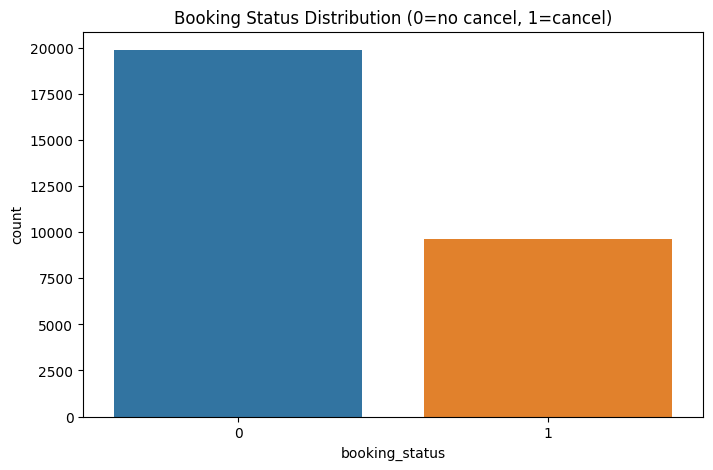

Insight 1: Check class balance. If heavily imbalanced, consider resampling/weights.


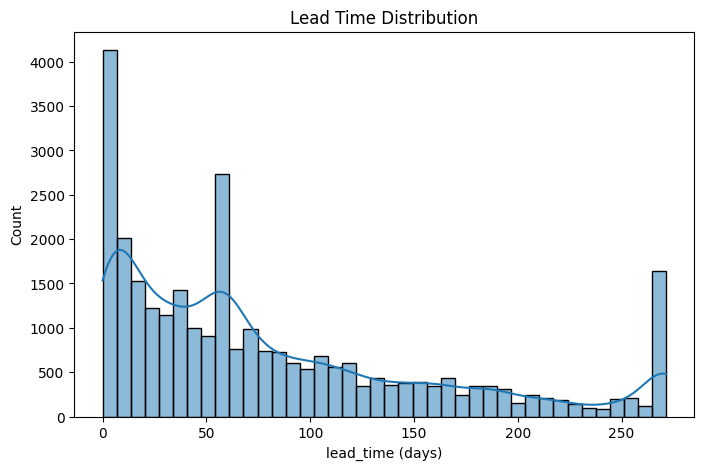

Insight 2: Lead time is likely right-skewed; long lead times are rarer but potentially informative.


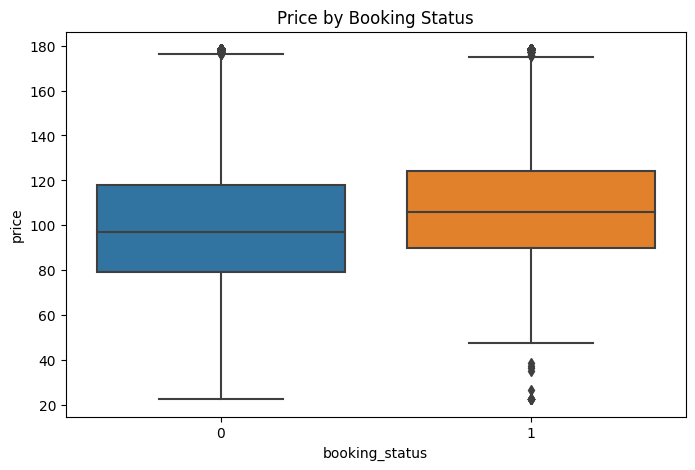

Insight 3: Look at median price per class and presence of outliers — price may influence cancellation behavior.


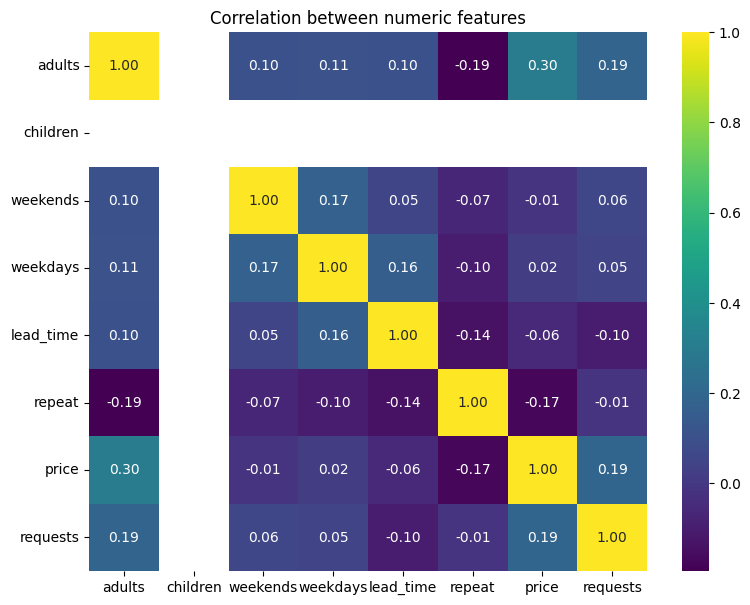

Insight 4: Use correlated numeric features accordingly; highly correlated features may be redundant.


In [14]:
# === 8. Visualizations and Insights ===
plt.rcParams['figure.figsize'] = (8,5)

# Booking status distribution
plt.figure()
sns.countplot(x=y)
plt.title('Booking Status Distribution (0=no cancel, 1=cancel)')
plt.show()
print("Insight 1: Check class balance. If heavily imbalanced, consider resampling/weights.")

# Lead time distribution
plt.figure()
sns.histplot(X['lead_time'], bins=40, kde=True)
plt.title('Lead Time Distribution')
plt.xlabel('lead_time (days)')
plt.show()
print("Insight 2: Lead time is likely right-skewed; long lead times are rarer but potentially informative.")

# Price vs Booking Status
plt.figure()
sns.boxplot(x=y, y=X['price'])
plt.title('Price by Booking Status')
plt.xlabel('booking_status')
plt.ylabel('price')
plt.show()
print("Insight 3: Look at median price per class and presence of outliers — price may influence cancellation behavior.")

# Correlation heatmap (numeric)
plt.figure(figsize=(9,7))
sns.heatmap(X[num_cols].corr(), annot=True, fmt=".2f", cmap='viridis')
plt.title('Correlation between numeric features')
plt.show()
print("Insight 4: Use correlated numeric features accordingly; highly correlated features may be redundant.")


**SCALING NUMERICAL FEATURES AND ENCODING CATEGORICAL FEATURS**

In [15]:
# === 9. Preprocessing: Scale numeric columns and OneHotEncode categorical columns ===
# Used ColumnTransformer + Pipeline for models
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse=False))
])

# Define final lists of columns (ensure these columns exist)
num_cols_final = [c for c in num_cols if c in X.columns]
cat_cols_final = [c for c in cat_cols if c in X.columns]

print("\nNumeric cols used:", num_cols_final)
print("Categorical cols used:", cat_cols_final)

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, num_cols_final),
    ('cat', categorical_transformer, cat_cols_final)
], remainder='drop')


Numeric cols used: ['adults', 'children', 'weekends', 'weekdays', 'lead_time', 'repeat', 'price', 'requests']
Categorical cols used: ['meal_type', 'room_type', 'arrival', 'segment']


In [16]:
# === 10. Train/Validation split ===
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)
print("\nTrain shape:", X_train.shape, "Val shape:", X_val.shape)



Train shape: (23600, 13) Val shape: (5900, 13)


**MODELBUILDING(7)**

In [17]:

# === 11. Model building: 7 models ===
models = {
    'LogisticRegression': LogisticRegression(max_iter=500, random_state=RND),
    'DecisionTree': DecisionTreeClassifier(random_state=RND),
    'RandomForest': RandomForestClassifier(n_jobs=-1, random_state=RND),
    'GradientBoosting': GradientBoostingClassifier(random_state=RND),
    'KNN': KNeighborsClassifier(),
    'SVC': SVC(probability=True, random_state=RND)
}
if XGB_AVAILABLE:
    models['XGBoost'] = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=RND)

# Train each model and evaluate on validation set
results = {}
trained_pipelines = {}

for name, model in models.items():
    pipe = Pipeline(steps=[('preprocessor', preprocessor), ('clf', model)])
    pipe.fit(X_train, y_train)
    preds = pipe.predict(X_val)
    proba = pipe.predict_proba(X_val)[:,1] if hasattr(pipe, 'predict_proba') else None
    acc = accuracy_score(y_val, preds)
    f1 = f1_score(y_val, preds)
    auc = roc_auc_score(y_val, proba) if proba is not None else np.nan
    results[name] = {'accuracy': acc, 'f1': f1, 'roc_auc': auc}
    trained_pipelines[name] = pipe
    print(f"{name}: accuracy={acc:.4f}, f1={f1:.4f}, roc_auc={'{:.4f}'.format(auc) if not np.isnan(auc) else 'N/A'}")

# Comparison table
results_df = pd.DataFrame(results).T.sort_values(by='accuracy', ascending=False)
print("\nModel comparison (validation):")
print(results_df)

LogisticRegression: accuracy=0.8139, f1=0.7002, roc_auc=0.8822
DecisionTree: accuracy=0.8642, f1=0.7899, roc_auc=0.8438
RandomForest: accuracy=0.8851, f1=0.8159, roc_auc=0.9390
GradientBoosting: accuracy=0.8454, f1=0.7443, roc_auc=0.8968
KNN: accuracy=0.8425, f1=0.7462, roc_auc=0.8948
SVC: accuracy=0.8536, f1=0.7597, roc_auc=0.9043
XGBoost: accuracy=0.8669, f1=0.7860, roc_auc=0.9258

Model comparison (validation):
                    accuracy        f1   roc_auc
RandomForest        0.885085  0.815861  0.938961
XGBoost             0.866949  0.786045  0.925847
DecisionTree        0.864237  0.789929  0.843844
SVC                 0.853559  0.759733  0.904268
GradientBoosting    0.845424  0.744251  0.896807
KNN                 0.842542  0.746244  0.894830
LogisticRegression  0.813898  0.700164  0.882157


**HYPERPARAMETER TUNING OF 3 MODELS AND COMPARISON OF MODELS**

In [18]:
# === 12. Hyperparameter tuning for 3 models ===
# Tuned RandomForest, GradientBoosting, and XGBoost 
tuned_models = {}

# RandomForest
rf_pipe = Pipeline(steps=[('preprocessor', preprocessor), ('clf', RandomForestClassifier(random_state=RND, n_jobs=-1))])
rf_params = {
    'clf__n_estimators': [100, 200],
    'clf__max_depth': [None, 10, 20]
}
rf_grid = GridSearchCV(rf_pipe, rf_params, cv=3, scoring='accuracy', n_jobs=-1)
print("\nTuning RandomForest...")
rf_grid.fit(X_train, y_train)
print("RF best params:", rf_grid.best_params_, "best_cv_score:", rf_grid.best_score_)
tuned_models['RandomForest_Tuned'] = rf_grid.best_estimator_

# GradientBoosting
gb_pipe = Pipeline(steps=[('preprocessor', preprocessor), ('clf', GradientBoostingClassifier(random_state=RND))])
gb_params = {
    'clf__n_estimators': [100, 200],
    'clf__learning_rate': [0.05, 0.1]
}
gb_grid = GridSearchCV(gb_pipe, gb_params, cv=3, scoring='accuracy', n_jobs=-1)
print("\nTuning GradientBoosting...")
gb_grid.fit(X_train, y_train)
print("GB best params:", gb_grid.best_params_, "best_cv_score:", gb_grid.best_score_)
tuned_models['GradientBoosting_Tuned'] = gb_grid.best_estimator_

# XGBoost (if available)
if XGB_AVAILABLE:
    xgb_pipe = Pipeline(steps=[('preprocessor', preprocessor), ('clf', XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=RND))])
    xgb_params = {
        'clf__n_estimators': [100, 200],
        'clf__learning_rate': [0.05, 0.1]
    }
    xgb_grid = GridSearchCV(xgb_pipe, xgb_params, cv=3, scoring='accuracy', n_jobs=-1)
    print("\nTuning XGBoost...")
    xgb_grid.fit(X_train, y_train)
    print("XGB best params:", xgb_grid.best_params_, "best_cv_score:", xgb_grid.best_score_)
    tuned_models['XGBoost_Tuned'] = xgb_grid.best_estimator_
else:
    print("\nXGBoost not available in environment; skipped XGB tuning.")

# Evaluate tuned models on validation set
print("\nEvaluation of tuned models on validation set:")
for name, pipe in tuned_models.items():
    preds = pipe.predict(X_val)
    proba = pipe.predict_proba(X_val)[:,1] if hasattr(pipe, 'predict_proba') else None
    acc = accuracy_score(y_val, preds)
    f1 = f1_score(y_val, preds)
    auc = roc_auc_score(y_val, proba) if proba is not None else np.nan
    print(f"{name}: accuracy={acc:.4f}, f1={f1:.4f}, roc_auc={'{:.4f}'.format(auc) if not np.isnan(auc) else 'N/A'}")


Tuning RandomForest...


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_outp

RF best params: {'clf__max_depth': None, 'clf__n_estimators': 200} best_cv_score: 0.8749997697223587

Tuning GradientBoosting...


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_outp

GB best params: {'clf__learning_rate': 0.1, 'clf__n_estimators': 200} best_cv_score: 0.8441948159401856

Tuning XGBoost...


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_outp

XGB best params: {'clf__learning_rate': 0.1, 'clf__n_estimators': 200} best_cv_score: 0.8591523641089086

Evaluation of tuned models on validation set:
RandomForest_Tuned: accuracy=0.8886, f1=0.8225, roc_auc=0.9388
GradientBoosting_Tuned: accuracy=0.8485, f1=0.7524, roc_auc=0.9035
XGBoost_Tuned: accuracy=0.8658, f1=0.7848, roc_auc=0.9241


**COMPARISON OF MODEL PERFORMANCES AND SELECTING BEST MODEL**

In [19]:
# === 13. all candidate models and picking best by validation accuracy ===
candidates = {}
candidates.update(trained_pipelines)
candidates.update(tuned_models)

best_name, best_acc = None, -1
for name, pipe in candidates.items():
    preds = pipe.predict(X_val)
    acc = accuracy_score(y_val, preds)
    if acc > best_acc:
        best_acc = acc
        best_name = name

print("\nSelected final model:", best_name, "with validation accuracy:", best_acc)
final_model = candidates[best_name]

#classification report and confusion matrix
val_preds = final_model.predict(X_val)
print("\nClassification report (validation) for final model:")
print(classification_report(y_val, val_preds))
print("Confusion matrix:\n", confusion_matrix(y_val, val_preds))


Selected final model: RandomForest_Tuned with validation accuracy: 0.8886440677966102

Classification report (validation) for final model:
              precision    recall  f1-score   support

           0       0.90      0.94      0.92      3974
           1       0.86      0.79      0.82      1926

    accuracy                           0.89      5900
   macro avg       0.88      0.86      0.87      5900
weighted avg       0.89      0.89      0.89      5900

Confusion matrix:
 [[3721  253]
 [ 404 1522]]


**PREDICT ON TEST SET AND SUBMISSION**

In [20]:
# === 14. Predict on test set and save submission ===

y_test_pred = final_model.predict(X_test)  # uses pipeline -> preprocessor inside

submission = pd.DataFrame({
    'id': range(0, X_test.shape[0]),
    'target': y_test_pred
})
submission.to_csv('submission.csv', index=False)
print("\nSaved submission.csv")




Saved submission.csv
